##### Figure 5
# HRRR forecasts hovemoller and pollywogs

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd, wind_spddir_to_uv

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b-%d\n%H:%M')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [two_column, 3]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .2
mpl.rcParams['grid.alpha'] = .8
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


In [3]:
# Get Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [4]:
stn = 'HWKC1'

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

In [5]:
def get_hrrr_point_UV(DATE):
    Hu = get_hrrr_variable(DATE, 'UGRD:10 m', fxx=fxx, verbose=False)
    Hv = get_hrrr_variable(DATE, 'VGRD:10 m', fxx=fxx, verbose=False)
    
    spd = wind_uv_to_spd(Hu['value'][x][y], Hv['value'][x][y])
    
    return spd

In [6]:
# Date Rage of valid time
sDATE = datetime(2017, 10, 8, 0)
eDATE = datetime(2017, 10, 10, 0)
hours = (eDATE-sDATE).days * 24 + (eDATE-sDATE).seconds /60/60

# List of valid dates
VALIDDATES = [sDATE+timedelta(hours=h) for h in range(hours+1)]

# Get Data for Hovemoller
data = {}
for fxx in range(19):
    # List of model initialized run
    INITDATES = [V-timedelta(hours=fxx) for V in VALIDDATES]
    timer = datetime.now()
    p = multiprocessing.Pool(14)
    result = p.map(get_hrrr_point_UV, INITDATES)
    p.close
    print 'finished %02d:' % fxx, datetime.now()-timer
    
    data[fxx] = result

finished 00: 0:00:11.358914
finished 01: 0:00:12.983626
finished 02: 0:00:12.776904
finished 03: 0:00:11.548212
finished 04: 0:00:10.280511
finished 05: 0:00:10.919560
finished 06: 0:00:11.056113
finished 07: 0:00:10.179331
finished 08: 0:00:11.154756
finished 09: 0:00:11.703437
finished 10: 0:00:11.027064
finished 11: 0:00:11.644688
finished 12: 0:00:11.547024
finished 13: 0:00:11.840009
finished 14: 0:00:11.839565
finished 15: 0:00:10.813520
finished 16: 0:00:11.271825
finished 17: 0:00:11.205059
finished 18: 0:00:11.474984


In [7]:
# Package HRRR hovemoller data for plotting
num = len(VALIDDATES)
dates = VALIDDATES
hovmoller = {'fxx_2d':np.array([np.ones(num)*i for i in range(19)]),
             'valid_2d':np.array([dates for i in range(19)]),
             'fxx_1d+':range(20),
             'valid_1d+':np.append(dates, dates[-1]+timedelta(hours=1)),
             'DATA':np.array([data[f] for f in range(19)])}

In [8]:
# Get mesowest observations
a = get_mesowest_ts(stn, sDATE-timedelta(hours=1), eDATE+timedelta(hours=1))

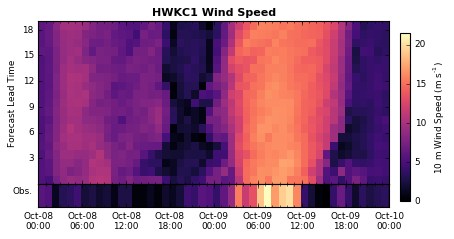

In [9]:
vmax = np.nanmax([np.nanmax(hovmoller['DATA']), np.nanmax(a['wind_speed'])])
vmin = 0
cmap = 'magma'

fig = plt.figure(1)
ax1 = plt.subplot2grid((8, 1), (0, 0), rowspan=7)
ax2 = plt.subplot(8, 1, 8)

hv = ax1.pcolormesh(hovmoller['valid_1d+'], hovmoller['fxx_1d+'], hovmoller['DATA'],
                    cmap=cmap,
                    vmax=vmax, vmin=vmin)
mw = ax2.pcolormesh(a['DATETIME'], range(2), [a['wind_speed'], a['wind_speed']],
                    cmap=cmap,
                    vmax=vmax, vmin=vmin)

ax1.axes.xaxis.set_ticklabels([])
ax1.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 6)))
ax1.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))
ax2.xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 6)))
ax2.xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))
ax2.xaxis.set_major_formatter(formatter)

ax1.set_ylim([0, 19])
ax1.set_yticks(range(3,19,3))
ax1.set_xlim([sDATE, eDATE])
ax1.set_ylabel('Forecast Lead Time')

ax2.set_yticks([])
ax2.set_xlim([sDATE, eDATE])
ax2.set_ylabel('Obs.', rotation=0, ha='right')

ax1.set_title(stn + ' Wind Speed', fontweight='semibold')

fig.subplots_adjust(hspace=0, right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cb = fig.colorbar(hv, cax=cbar_ax, ticks=range(0,25,5))
cb.ax.set_ylabel(r'10 m Wind Speed (m s$\mathregular{^{-1}}$)')

plt.savefig('./figs/Fig_05a_%s_hovmoller' % stn)

##### testing

(736610.0, 736612.0)

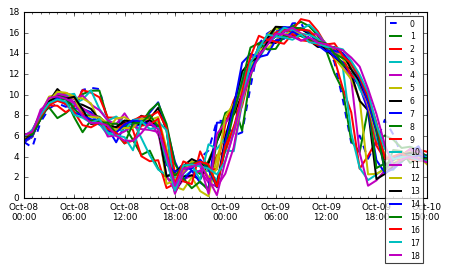

In [10]:
# Testing
for i in data:
    if i==0:
        plt.plot(VALIDDATES,data[i], label=i, linestyle='--')
    else:
        plt.plot(VALIDDATES,data[i], label=i)

plt.legend()
    
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 6)))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))

plt.xlim([sDATE, eDATE])

# HRRR Pollywog

In [11]:
# Extract Pollywog from Hovmoller array
hours_from_sDATE = range(0, 48, 3)
pollywogs = {}
for index in hours_from_sDATE:
    validtime = []
    pollywog = []
    for f in range(19):
        try:
            pollywog.append(hovmoller['DATA'][f, f+index])
            validtime.append(VALIDDATES[index]+timedelta(hours=f))
        except:
            # data out of range of what was retrieved
            pass
    pollywogs[index] = {'valid': validtime,
                        'polly': pollywog}

In [12]:
# Retrieve Percentiles
def get_point_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE, STAT, ROW, COL = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT][x][y]
    except:
        #print "COULD NOT GET", FILE
        return np.nan

In [13]:
percentiles = [0, 1, 2, 3, 4, 5, 25, 50, 75, 95, 96, 97, 98, 99, 100]
var = 'UVGRD:10 m'
fxx = 0
hours = range(24)

variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

HTS = OrderedDict()
for i, pp in enumerate(percentiles):
    # Multiprocessing :)
    stat = 'p%02d' % pp
    args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, D.month, D.day, D.hour), stat, point[0][0], point[1][0]] for D in VALIDDATES]
    timer = datetime.now()
    num_proc = multiprocessing.cpu_count()
    p = multiprocessing.Pool(num_proc)
    HTS[stat] = np.array(p.map(get_point_MP, args))
    p.close()

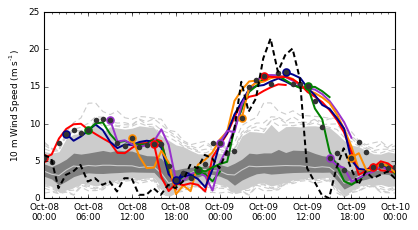

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0, right=0.8)
# Background OSG Percentiles
plt.fill_between(VALIDDATES,
                 HTS['p95'], HTS['p05'],
                 facecolor=[.8, .8, .8],
                 linewidth=0,
                 label='HRRR p05-p95')
plt.fill_between(VALIDDATES,
                 HTS['p75'], HTS['p25'],
                 facecolor=[.5, .5, .5],
                 linewidth=0,
                 label='HRRR p25-p75')
plt.plot(VALIDDATES,
         HTS['p50'],
         color=[.8, .8, .8],
         lw=1,
         label='HRRR p50',
         zorder=1)
for i in [1,2,3,4,96, 97, 98, 99]:
    plt.plot(VALIDDATES,
             HTS['p%02d' % i],
             color=[.8, .8, .8],
             lw=1,
             linestyle='--', dashes=(5,3),
             label='HRRR p%02d' % i,
             zorder=1)


# Cycle pollywogs through these colors.
colors = ['red', 'darkblue', 'green', 'darkorchid', 'darkorange'] * 50
color_count = 0
for p in hours_from_sDATE:
    plt.scatter(pollywogs[p]['valid'][0], pollywogs[p]['polly'][0],
                s=60,
                lw=0,
                c=colors[color_count],
                zorder=2)
    plt.plot(pollywogs[p]['valid'], pollywogs[p]['polly'],
             c=colors[color_count],
             zorder=1)
    color_count += 1

plt.scatter(VALIDDATES, hovmoller['DATA'][0],
            c=[.2, .2, .2],
            s=25,
            lw=0,
            zorder=3)

plt.plot(a['DATETIME'], a['wind_speed'],
         color='k',
         linestyle='--', dashes=(5, 3),
         zorder=5)

plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(range(0, 24, 6)))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(range(0, 24, 1)))

plt.xlim([sDATE, eDATE])
plt.ylim([0,25])

plt.ylabel(r'10 m Wind Speed (m s$\mathregular{^{-1}}$)')

#plt.title(stn + ' Wind Speed', fontweight='semibold')
plt.savefig('./figs/Fig_05b_%s_timeseries_pollywog_percentiles_mesowest' % (stn))